In [55]:
from qiskit import transpile ,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator, DensityMatrix, partial_trace, Pauli
from qiskit.visualization import plot_state_qsphere
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RYGate, RZGate, CXGate, CRYGate, n_local
import numpy as np, array
from IPython.display import display, Latex
# SciPy minimizer routine
from scipy.optimize import minimize
#from skquant.interop.scipy import imfil
import time
from pathlib import Path
from qadc.circuits import *
from qadc.utils import *
from qadc.circuits import BaseAmplitudeDampingCircuit as BADC
from qadc.simulators import *
from qiskit.quantum_info import Statevector
from qiskit.circuit import ClassicalRegister
project_root = Path().resolve().parents[1]/"result"/"risultati_ad_entanglement"
print(project_root)
print(project_root.exists())

C:\Users\rem.gabryldellarosa\OneDrive - Universita degli Studi Roma Tre\Desktop\Tesi\quantum-amplitude-damping-channel\result\risultati_ad_entanglement
True


In [56]:
def crea_cartelle_risultati(base_dir="risultati_ottimizzatore"):
    import os
    """
    Crea la struttura di cartelle per salvare i risultati dell'ottimizzazione.
    
    Parametri:
        base_dir (str): cartella principale in cui salvare i risultati
        lista_eta (list): lista dei valori η per cui creare le sottocartelle
    """
    path_root = os.path.join(base_dir, "risultati")
    os.makedirs(path_root, exist_ok=True)
    path_andamento = os.path.join(path_root, "risultati_ottimizzazione")
    path_bloch = os.path.join(path_root, "visualizzazione_risultati")

    # Crea le due cartelle principali
    os.makedirs(path_andamento, exist_ok=True)
    os.makedirs(path_bloch, exist_ok=True)
    return [path_root,path_andamento,path_bloch]

    

def salva_plot_png(fig, base_name = "grafico",base_dir="risultati_ottimizzatore", subfolder="risultati_ottimizzazione", _create = False, name_create =""):
    import os
    """
    Salva un plot matplotlib in una cartella strutturata in base al valore del damping (noise).

    Parameters:
    - fig: oggetto matplotlib.figure.Figure
    - noise_value: valore di eta o n usato per la simulazione
    - base_dir: cartella radice per i risultati
    - subfolder: sotto-cartella per tipo di contenuto
    """
    dir_path = os.path.join(base_dir,subfolder)
    if _create == True:
        dir_path = os.path.join(dir_path, name_create)
        os.makedirs(dir_path, exist_ok=True)

    filename = os.path.join(dir_path, base_name+".png")
    fig.savefig(filename, dpi=300, bbox_inches='tight')

def salva_plot_plotly(fig, base_name = "grafico_3D_eta_",base_dir="risultati_ottimizzatore", subfolder="visualizzazione_risultati",_create = False, name_create = None):
    import os
    """
    Salva un plot Plotly (interattivo) come HTML in una struttura di cartelle.

    Parameters:
    - fig: oggetto plotly.graph_objects.Figure
    - noise_value: valore di eta o n usato per la simulazione
    - base_dir: cartella radice per i risultati
    - subfolder: sotto-cartella per tipo di contenuto
    """
    dir_path = os.path.join(base_dir,subfolder)
    if _create == True:
        dir_path = os.path.join(dir_path, f""+name_create)
        os.makedirs(dir_path, exist_ok=True)

    filename = os.path.join(dir_path, base_name)
    fig.write_html(filename+".html")
   # fig.write_image(filename+".png",width=1200, height=900, scale=1)


# Fase 1 Modellare il problema

## Modello Ancilla & Encoding

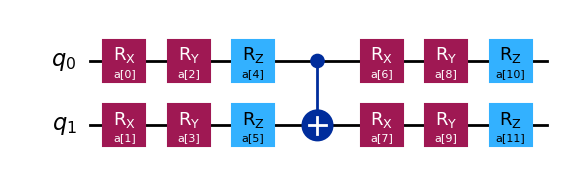

In [3]:

# 2 qubit, rotazioni RX/RY/RZ, entanglement CNOT
En = n_local(num_qubits=2,
              rotation_blocks=['rx', 'ry', 'rz'],
              entanglement_blocks='cx',
              reps=1,        # quante volte ripetere lo schema
              parameter_prefix="a",
              insert_barriers=False)

qc = QuantumCircuit(4,2)
# Possiamo per il momento omettere l'ottimizzazione di stati misti, per questo scelgo invece di 6 qubit, 4 qubit di cui 2 
# di sistema e 2 di ambiente
# qc.compose(AncillaInitializationCircuit(Parameter("A")),[0,2], inplace=True )
# qc.compose(AncillaInitializationCircuit(Parameter("B")),[3,5], inplace=True )

qc.compose(En, [0,2], inplace=True) # con ancilla avrò [0,3]

display(En.draw("mpl"))
#display(qc.draw("mpl"))

## Modello Decoding 

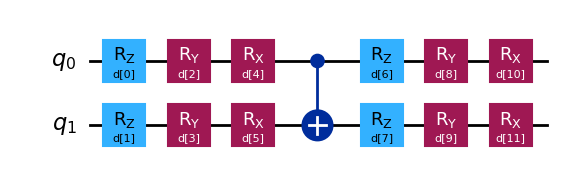

In [4]:
De = n_local(num_qubits=2,
              rotation_blocks=['rz', 'ry', 'rx'],
              entanglement_blocks='cx',
              reps=1,        # quante volte ripetere lo schema
              parameter_prefix="d",
              insert_barriers=False)
De.draw("mpl")

## Modello completo del canale

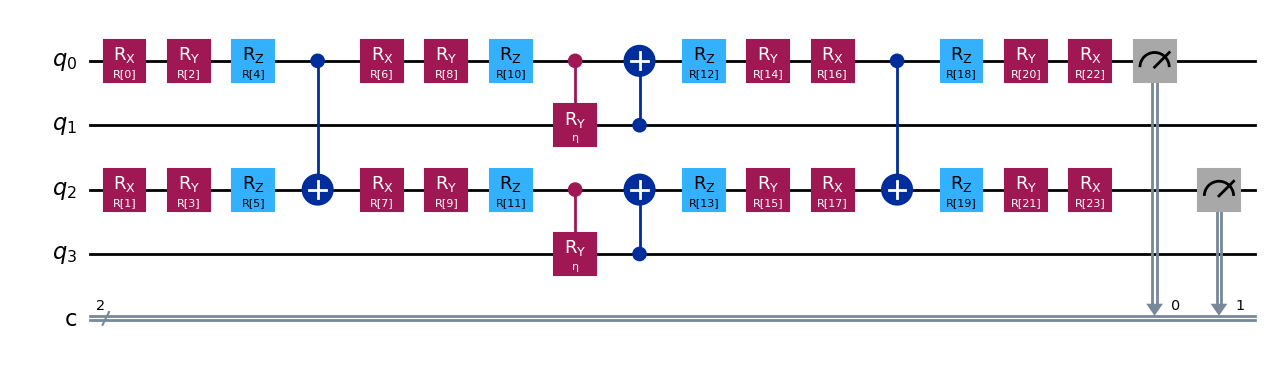

In [5]:
Ad = AmplitudeDampingConvenzioneQiskit()
noise = Ad.parameters.data[0]
qc.compose(Ad,[0,1], inplace = True) # con ancilla rimane cosi
qc.compose(Ad,[2,3], inplace = True) # con ancilla avrò 
qc.compose(De, [0,2], inplace = True)

param_circuit = qc.parameters.data
param_circuit.remove(Ad.parameters.data[0])
qc.measure(0,0)
qc.measure(2,1)

qc_exp = qc.copy()
new_param_circuit = ParameterVector("R", len(param_circuit))
qc.assign_parameters({ param_circuit[i] : new_param_circuit[i] for i in range(qc.num_parameters-1)}, inplace=True)
qc.draw("mpl")
# qc.assign_parameters({noise:0},inplace=True)
# result = IdealSimulator().run([(qc,np.random.uniform(0, 2 * np.pi, size=qc.num_parameters),1000),(qc,np.random.uniform(0, 2 * np.pi, size=qc.num_parameters),1000)])
# counts = result[0].data.c.get_counts()
# cost = Utils.cost_function([result[i].data.c.get_counts() for i in range(2)])
# print(result[0].data.c.get_counts(),cost)

## Canale da utilizzare in ottimizzazione 

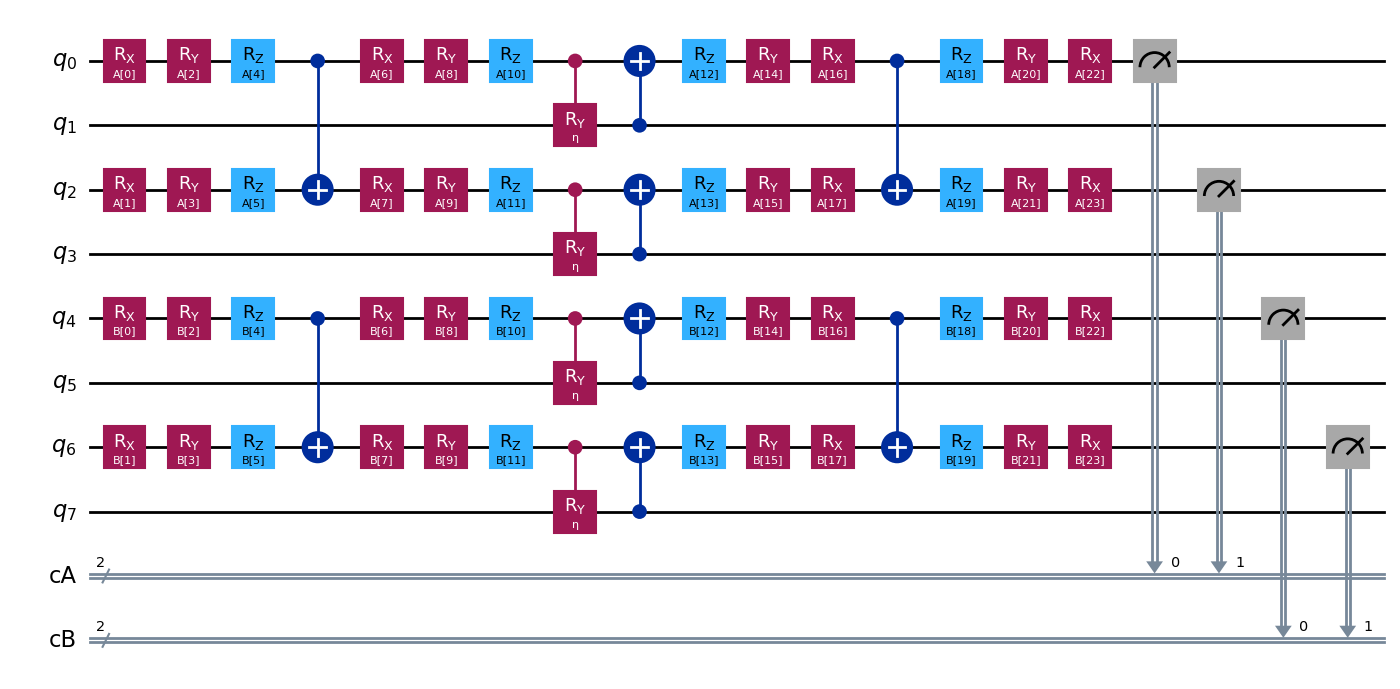

In [6]:
qc_be_opt = QuantumCircuit(8)
qc_be_opt.add_register(ClassicalRegister(2,"cA"))
qc_be_opt.add_register(ClassicalRegister(2,"cB"))
paramsA = ParameterVector("A", len(param_circuit))
paramsB = ParameterVector("B", len(param_circuit))
qc_a = qc.assign_parameters({new_param_circuit[i]:paramsA[i] for i in range(len(param_circuit))})
qc_b = qc.assign_parameters({new_param_circuit[i]:paramsB[i] for i in range(len(param_circuit))})
qc_be_opt.compose(qc_a,[i for i in range(qc_a.num_qubits)],[0,1],inplace=True)
qc_be_opt.compose(qc_b,[qc_a.num_qubits+i for i in range(qc_b.num_qubits)], [2,3],inplace=True)
# qc_be_opt.assign_parameters({noise:0},inplace=True)
# qc_be_opt.assign_parameters(range(qc_be_opt.num_parameters),inplace=True)
display(qc_be_opt.draw("mpl"))
# # qc
# print(qc_be_opt.parameters)
# result = IdealSimulator().run([(qc_be_opt,
#                                 #np.random.uniform(0, 2 * np.pi, size=qc_be_opt.num_parameters)
#                                 [], 
#                                 1000)])
# counts = [ result[0].data[c].get_counts() for c in result[0].data]
# print(counts)

# simulazione e ottimizzazione

## Funzioni ausiliari

In [57]:
def cost_function(counts):
    """
    Calcola la stima della probabilità di errore media degli esiti di misura utilizzando il metodo della massima verosimiglianza.

    Parametri:
    -----------
    counts : list of dict
        Lista di dizionari. Ogni dizionario rappresenta i conteggi di misura
        per una diversa classe (o esperimento), con chiavi '0' e '1' che indicano
        il numero di volte in cui ciascun risultato è stato ottenuto.

        Esempio:
            counts = [
                {'0': 900, '1': 100},   # Esperimento A
                {'0': 200, '1': 800}    # Esperimento B
            ]

    Ritorna:
    --------
    float
        Valore della funzione costo
    """
    return Utils.cost_function(counts)

def merge_dict(dicts):
    """
    Unisce una lista di dizionari in un singolo dizionario, in cui i valori associati
    a ciascuna chiave sono raccolti in una lista ordinata.

    Parametri:
    -----------
    dicts : list of dict
        Una lista di dizionari, tutti con lo stesso insieme di chiavi (o parzialmente sovrapposti).
        Esempio:
            [{'a': 1, 'b': 2}, {'a': 3, 'b': 4}, {'a': 5, 'b': 6}]

    Ritorna:
    --------
    dict
        Un dizionario in cui ogni chiave è associata a una lista di valori
        raccolti nell'ordine dei dizionari originali.
        Esempio output:
            {'a': [1, 3, 5], 'b': [2, 4, 6]}
    """
    return Utils.merge_dict(dicts)

## Funzioni costo wrapper

In [8]:
def cost_wrapper_scipy_mode_1(theta_vector,qc,shots,mode : AbstractSimulator,cost_history):
    # mettere la gestione dei parametri in un metodo del circuito stesso
    if not(len(theta_vector) == 2*qc.num_parameters): 
        raise ValueError(f"Attesi {2*qc.num_parameters} parametri")
    params = qc.parameters
    result = mode.run([(qc,{ params[i] :theta_vector[i] for i in range(qc.num_parameters)}, shots),(qc,{ params[i] :theta_vector[i+qc.num_parameters] for i in range(qc.num_parameters)}, shots)])
    #counts = result[0].data.c.get_counts()
    # Estrae i conteggi delle misure per ogni esperimento, che dovrebbero essere 2.
    # Passa questi conteggi alla funzione costo, che valuta quanto sono statisticamente separabili.
    #cost = cost_function([marginal_counts(counts,[i]) for i in range(len(next(iter(counts))))])
    cost = cost_function([i.data[c].get_counts() for i in result for c in i.data])
    cost_history.append([cost] + list(theta_vector))
    #print([cost] + list(theta_vector))
    return cost

In [9]:
def cost_wrapper_scipy_mode_2(theta_vector,qc,shots,mode : AbstractSimulator,cost_history):
    # mettere la gestione dei parametri in un metodo del circuito stesso
    if not(len(theta_vector) == qc.num_parameters): 
        raise ValueError(f"Attesi {qc.num_parameters} parametri")
    params = qc.parameters
    result = mode.run([(qc,theta_vector,shots)])
    #counts = result[0].data.c.get_counts()
    # Estrae i conteggi delle misure per ogni esperimento, che dovrebbero essere 2.
    # Passa questi conteggi alla funzione costo, che valuta quanto sono statisticamente separabili.
    #cost = cost_function([marginal_counts(counts,[i]) for i in range(len(next(iter(counts))))])
    cost = cost_function([i.data[c].get_counts() for i in result for c in i.data])
    cost_history.append([cost] + list(theta_vector))
    #print([cost] + list(theta_vector))
    return cost

## Ottimizzazione con COBYQA

In [67]:
save = True
if save:
    radice, risultati, visualizzazione = crea_cartelle_risultati(project_root)
noises = np.linspace(0, 0.9, 5)
x0 = np.random.uniform(0, 2 * np.pi, size=(qc_be_opt.num_parameters-1))
# noises=[0.225]
print(x0)
met0 = "COBYQA"
met1 = "COBYQA"
mode = IdealSimulator()

[3.10007119 5.77438293 2.42762535 5.62545885 5.55354872 1.88874379
 6.2193521  5.11828496 3.17737878 4.83149753 5.84359141 3.26535191
 6.01146834 5.28176297 2.37814136 3.14263564 5.10657473 0.36197728
 0.7786517  0.24844372 0.39833865 3.98825741 6.28072871 0.18983979
 4.88566542 1.04702439 4.18788615 2.80141208 6.10095906 4.34215313
 3.12127546 4.86234054 3.67044582 5.0988726  2.56942082 2.96127467
 0.68313018 1.52313139 5.69638211 4.09225158 4.21677563 1.7113271
 3.92754644 1.2947921  2.2899677  2.40829833 2.09106615 1.88616618]


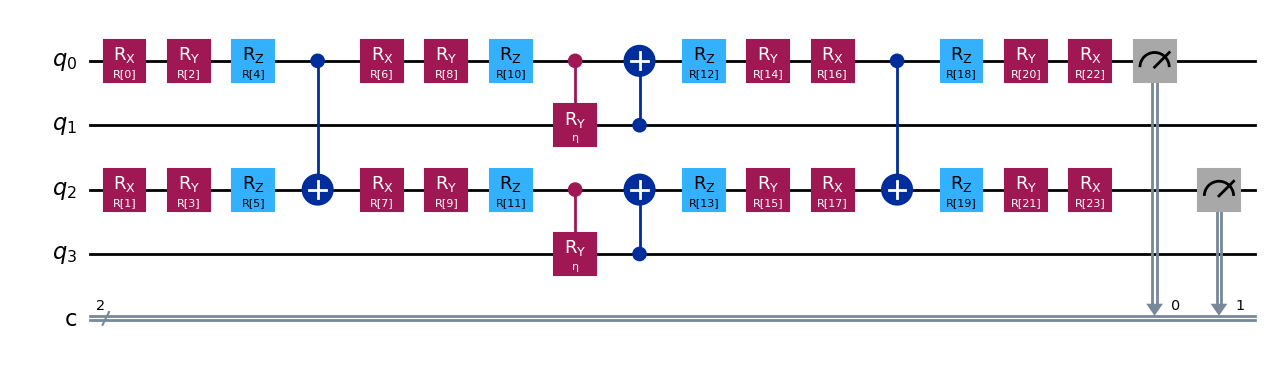

Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 0.0001.
Maximum number of function evaluations: 24000.
Maximum number of iterations: 220.

cost_wrapper_scipy_mode_1([ 3.146e+00  0.000e+00 ...  0.000e+00  3.229e+00]) = 0.44700000000000006
cost_wrapper_scipy_mode_1([ 4.146e+00  0.000e+00 ...  0.000e+00  3.229e+00]) = 0.34099999999999997
cost_wrapper_scipy_mode_1([ 3.146e+00  1.000e+00 ...  0.000e+00  3.229e+00]) = 0.43699999999999994
cost_wrapper_scipy_mode_1([ 3.146e+00  0.000e+00 ...  0.000e+00  3.229e+00]) = 0.38849999999999996
cost_wrapper_scipy_mode_1([ 3.146e+00  0.000e+00 ...  0.000e+00  3.229e+00]) = 0.391
cost_wrapper_scipy_mode_1([ 3.146e+00  0.000e+00 ...  0.000e+00  3.229e+00]) = 0.36450000000000005
cost_wrapper_scipy_mode_1([ 3.146e+00  0.000e+00 ...  0.000e+00  3.229e+00]) = 0.42599999999999993
cost_wrapper_scipy_mode_1([ 3.146e+00  0.000e+00 ...  0.000e+00  3.229e+00]) = 0.35050000000000003
cost_wrapper_scipy_mode_1([ 3.146

In [ ]:
if save :
    salva_plot_png(qc.draw("mpl"), base_name = "circuito_ottimizzazione", base_dir=radice,subfolder=risultati, _create=True)
display(qc.draw("mpl"))
all_simulation = []
for n in noises:
    start_time = time.time()
    cost_history = []
    qc_set_noise = qc.assign_parameters({noise : n})
    cost_wrapper_scipy_mode_1(x0,qc_set_noise, 10000, mode, cost_history)
    result = minimize(
        cost_wrapper_scipy_mode_1,
        x0,
        args=(qc_set_noise, 1000, mode, cost_history),
        method=met0,
        bounds=np.array(list([(-0*np.pi, 2*np.pi)]*2*(qc.num_parameters-1))),
        tol = 0.0001,
        options={
                "maxiter": 220, 
                "disp": True,
                }
    )
    # result = minimize(
    #     cost_wrapper_scipy,
    #     result.x,
    #     args=(qc_set_noise, 500000, mode, cost_history),
    #     method=met1,
    #     bounds=np.array(list([(-0*np.pi, 2*np.pi)]*2*(qc.num_parameters-1))),
    #     tol = 0.000001,
    #     options={
    #             "maxiter": 200, 
    #             "disp": True,
    #             }
    # )
    all_simulation.append((result,cost_history,n))
    end_time = time.time()
    execution_time = end_time - start_time
    print(result)
    print(f"""print optimal parameters: {result.x}""")
    print(f"""Number of iterations: {result.nfev}""")
    print(f"""Time (s): {execution_time}""")
    print(f"""result: {result.fun}""")

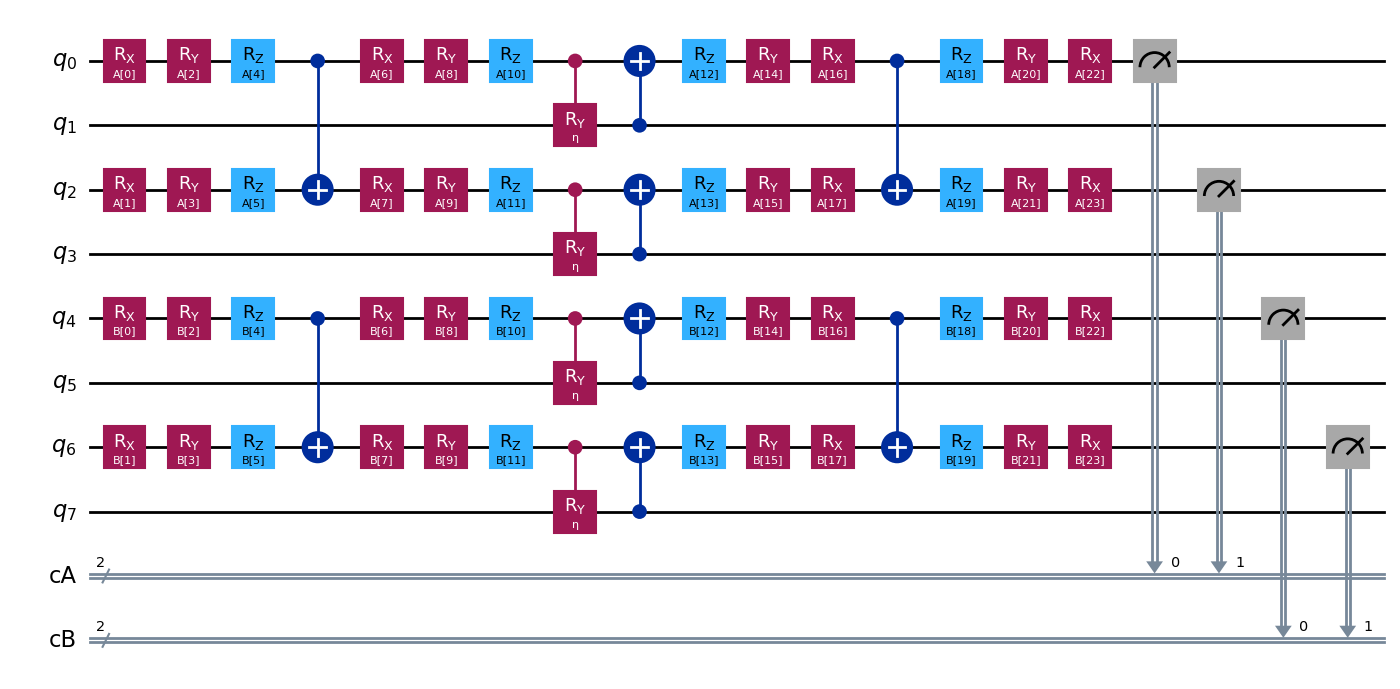

Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 0.0001.
Maximum number of function evaluations: 24000.
Maximum number of iterations: 400.

cost_wrapper_scipy_mode_2([ 3.715e+00  2.131e+00 ...  3.013e+00  1.000e+00]) = 0.30635
cost_wrapper_scipy_mode_2([ 4.715e+00  2.131e+00 ...  3.013e+00  1.000e+00]) = 0.36067499999999997
cost_wrapper_scipy_mode_2([ 3.715e+00  3.131e+00 ...  3.013e+00  1.000e+00]) = 0.40907499999999997
cost_wrapper_scipy_mode_2([ 3.715e+00  2.131e+00 ...  3.013e+00  1.000e+00]) = 0.327025
cost_wrapper_scipy_mode_2([ 3.715e+00  2.131e+00 ...  3.013e+00  1.000e+00]) = 0.27760000000000007
cost_wrapper_scipy_mode_2([ 3.715e+00  2.131e+00 ...  3.013e+00  1.000e+00]) = 0.35885
cost_wrapper_scipy_mode_2([ 3.715e+00  2.131e+00 ...  3.013e+00  1.000e+00]) = 0.2992
cost_wrapper_scipy_mode_2([ 3.715e+00  2.131e+00 ...  3.013e+00  1.000e+00]) = 0.29055
cost_wrapper_scipy_mode_2([ 3.715e+00  2.131e+00 ...  3.013e+00  1.000e+00]) = 

In [ ]:
if save : 
    salva_plot_png(qc_be_opt.draw("mpl"), base_name = "circuito_ottimizzazione", base_dir=radice,subfolder=risultati, _create=True)
display(qc_be_opt.draw("mpl"))
all_simulation = []

for n in noises:
    start_time = time.time()
    cost_history = []
    qc_set_noise = qc_be_opt.assign_parameters({noise : n})
    cost_wrapper_scipy_mode_2(x0,qc_set_noise, 10000, mode, cost_history)
    result = minimize(
        cost_wrapper_scipy_mode_2,
        x0,
        args=(qc_set_noise, 20000, mode, cost_history),
        method=met0,
        bounds=np.array(list([(-0*np.pi, 2*np.pi)]*qc_set_noise.num_parameters)),
        tol = 0.0001,
        options={
                "maxiter": 400, 
                "disp": True,
                }
    )
    # result = minimize(
    #     cost_wrapper_scipy,
    #     result.x,
    #     args=(qc_set_noise, 500000, mode, cost_history),
    #     method=met1,
    #     bounds=np.array(list([(-0*np.pi, 2*np.pi)]*2*(qc.num_parameters-1))),
    #     tol = 0.000001,
    #     options={
    #             "maxiter": 200, 
    #             "disp": True,
    #             }
    # )
    all_simulation.append((result,cost_history,n))
    end_time = time.time()
    execution_time = end_time - start_time
    print(result)
    print(f"""print optimal parameters: {result.x}""")
    print(f"""Number of iterations: {result.nfev}""")
    print(f"""Time (s): {execution_time}""")
    print(f"""result: {result.fun}""")

# Risultati

## Salva dati in un file formato {"input" : x0, "results" : all_simulations}

In [68]:
import pickle

with open(radice+"/data.pkl", "wb") as f:
    pickle.dump({"input":x0,"results":all_simulation}, f)

## Leggi dati da un file 

In [70]:
import pickle

with open(radice+"/data.pkl", "rb") as f:
    data = pickle.load(f)
x0 = data["input"]
all_simulation = data["results"]

## grafici funzione costo

C:\Users\rem.gabryldellarosa\AppData\Local\Temp\ipykernel_21792\2566477677.py:55: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


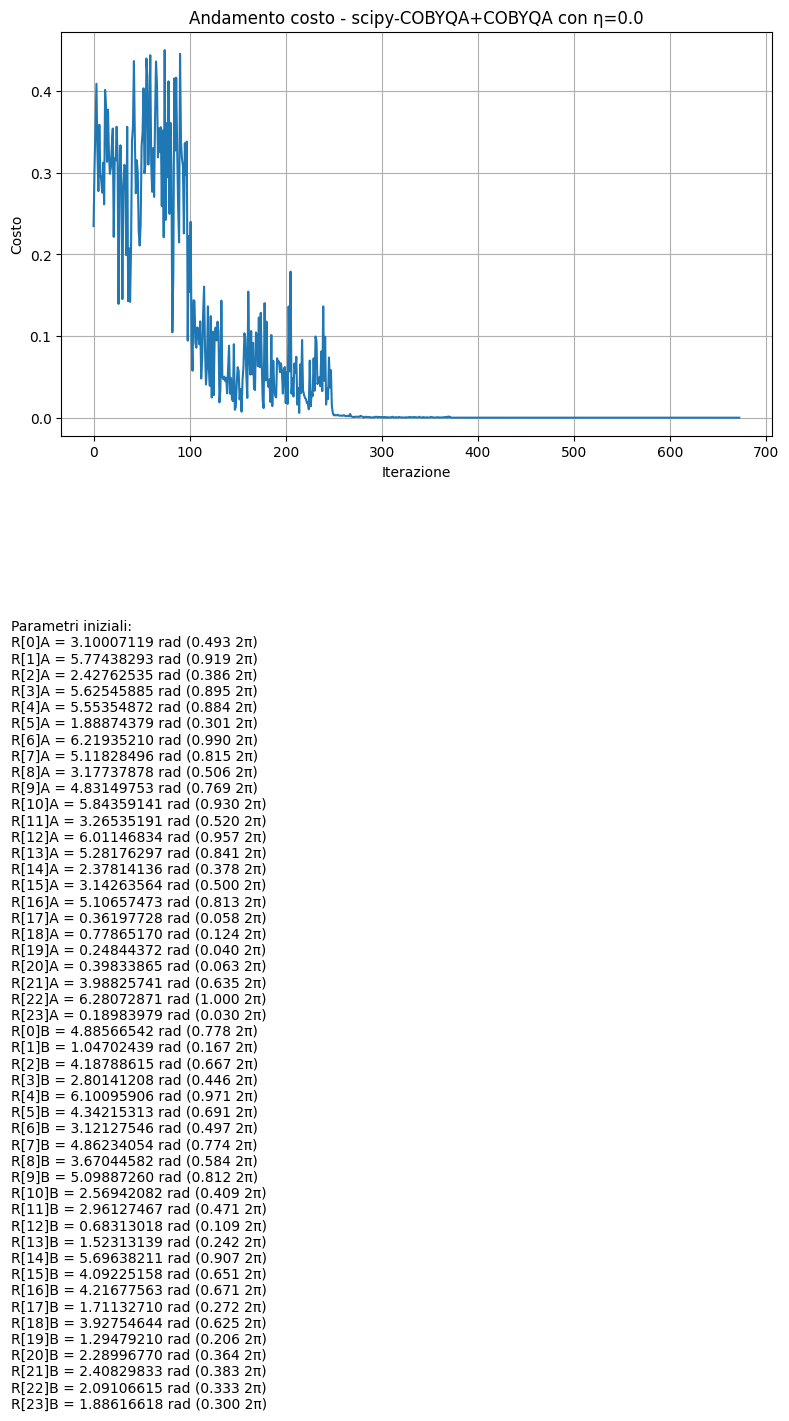

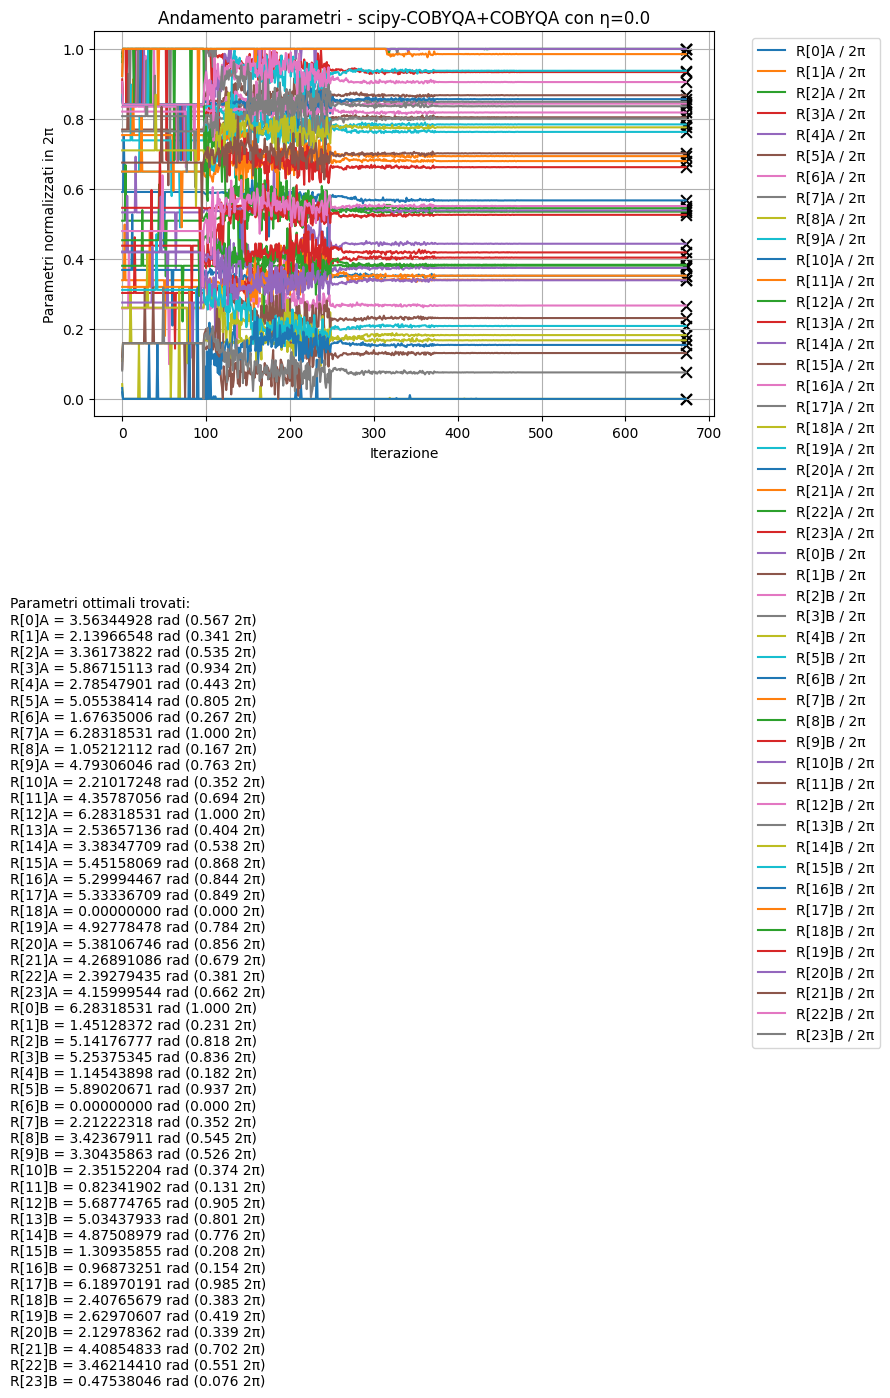

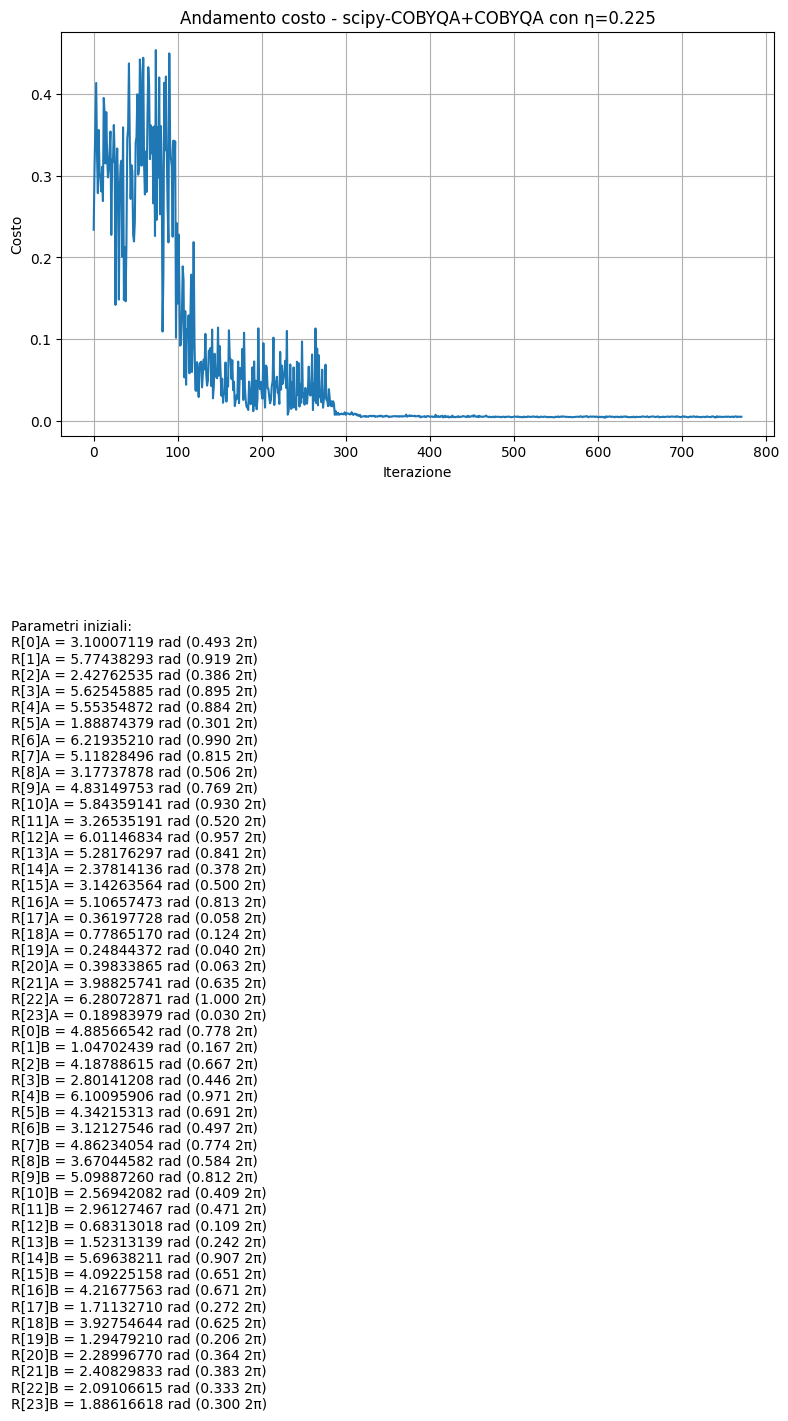

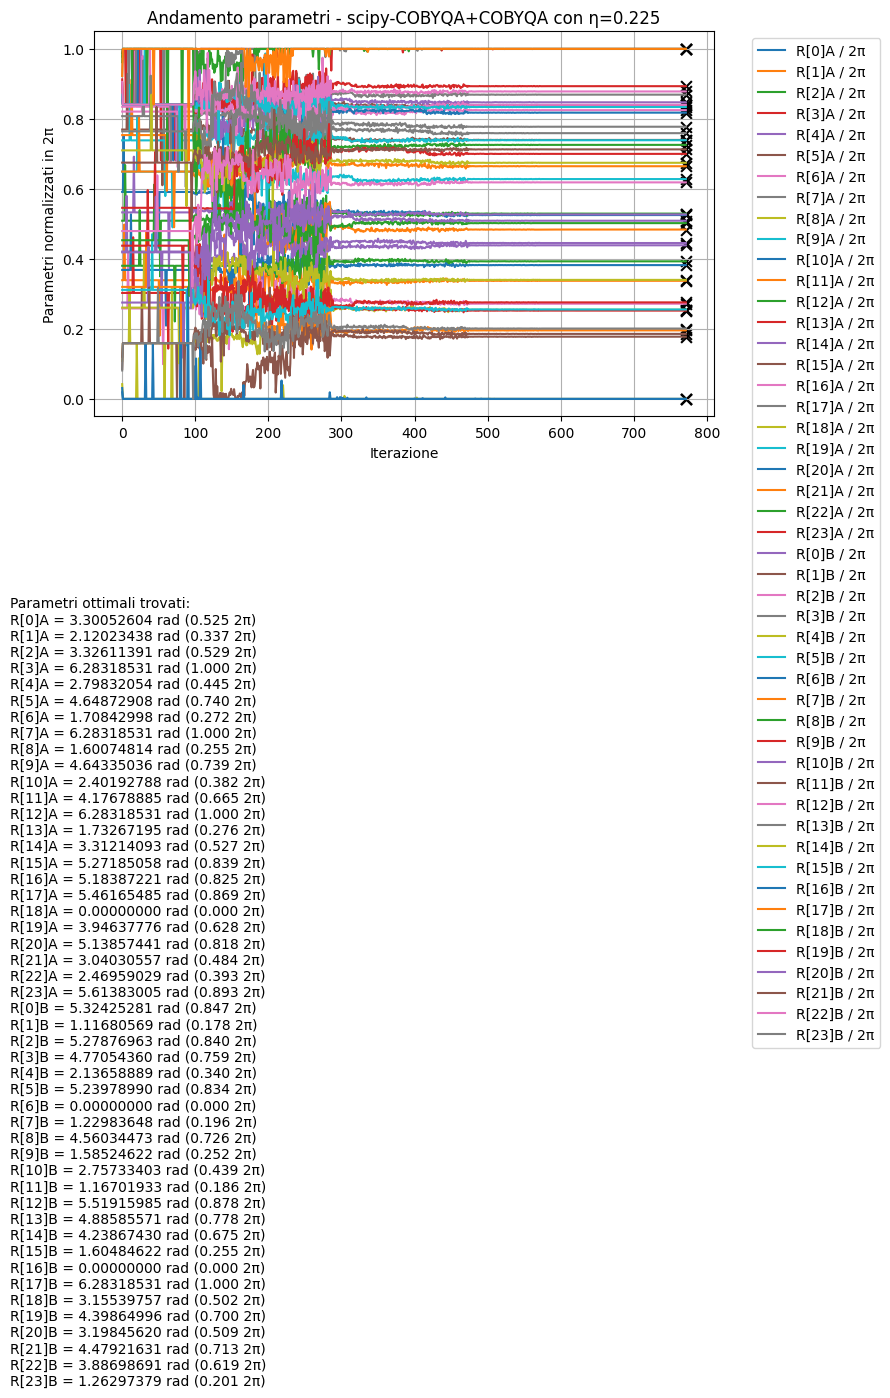

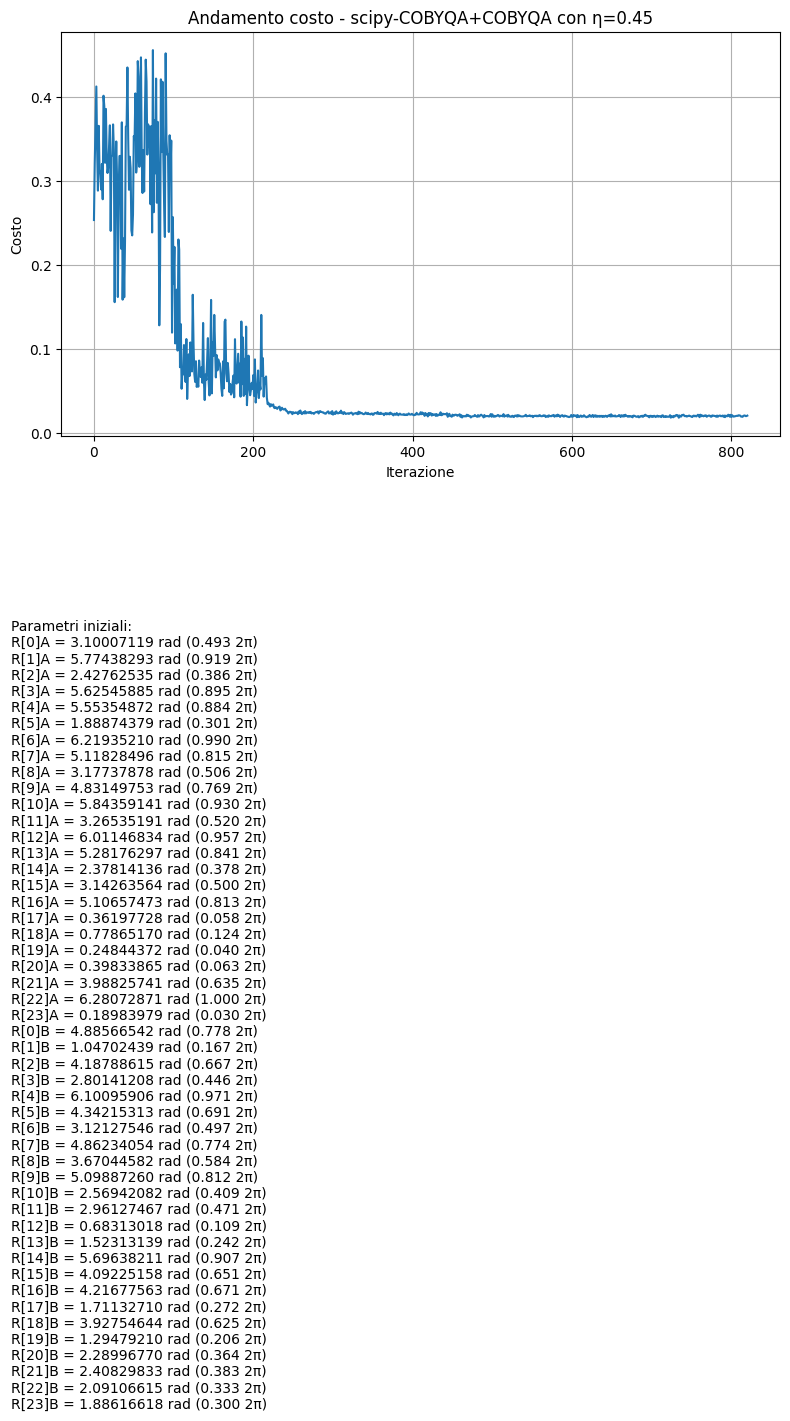

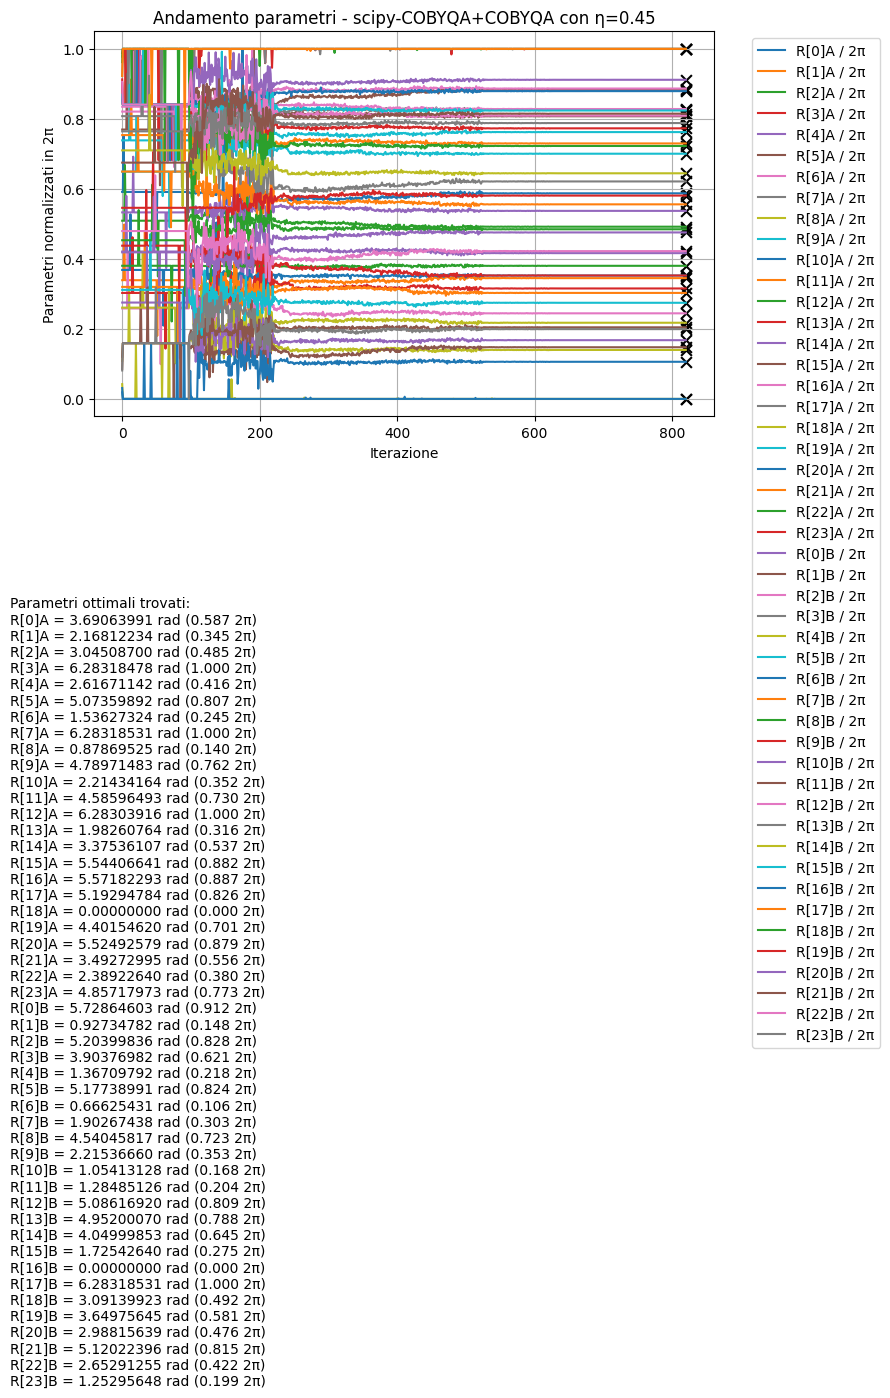

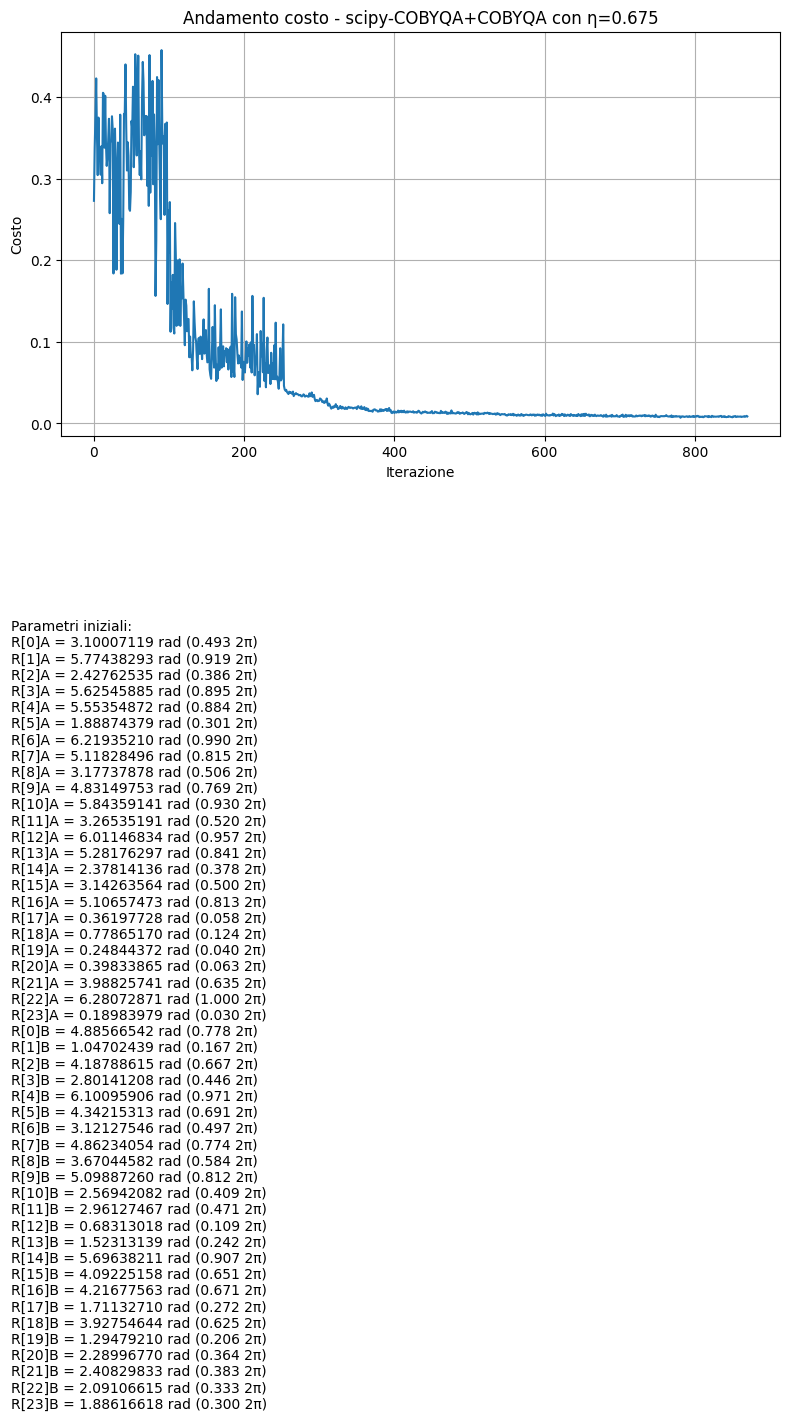

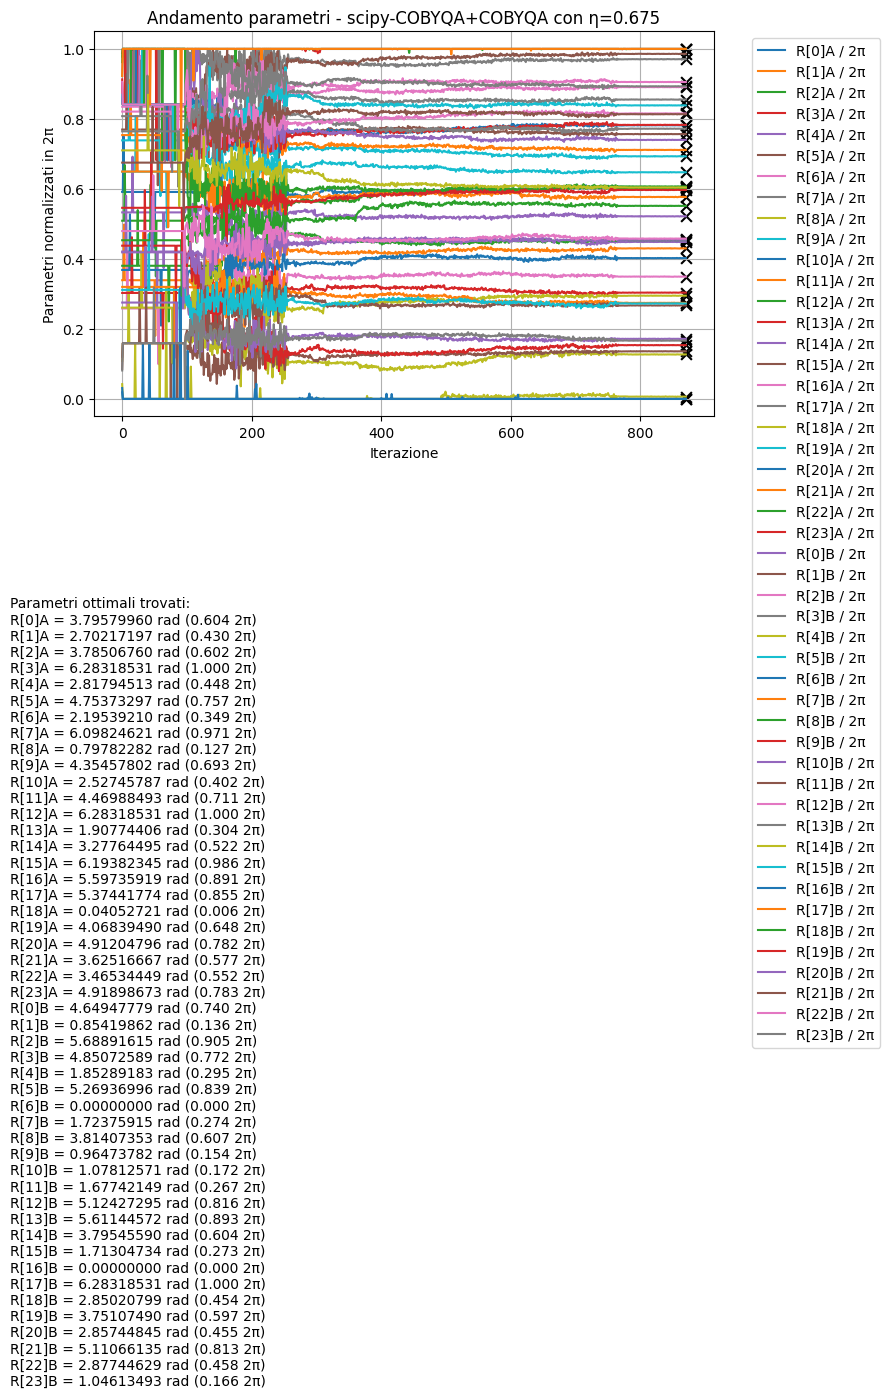

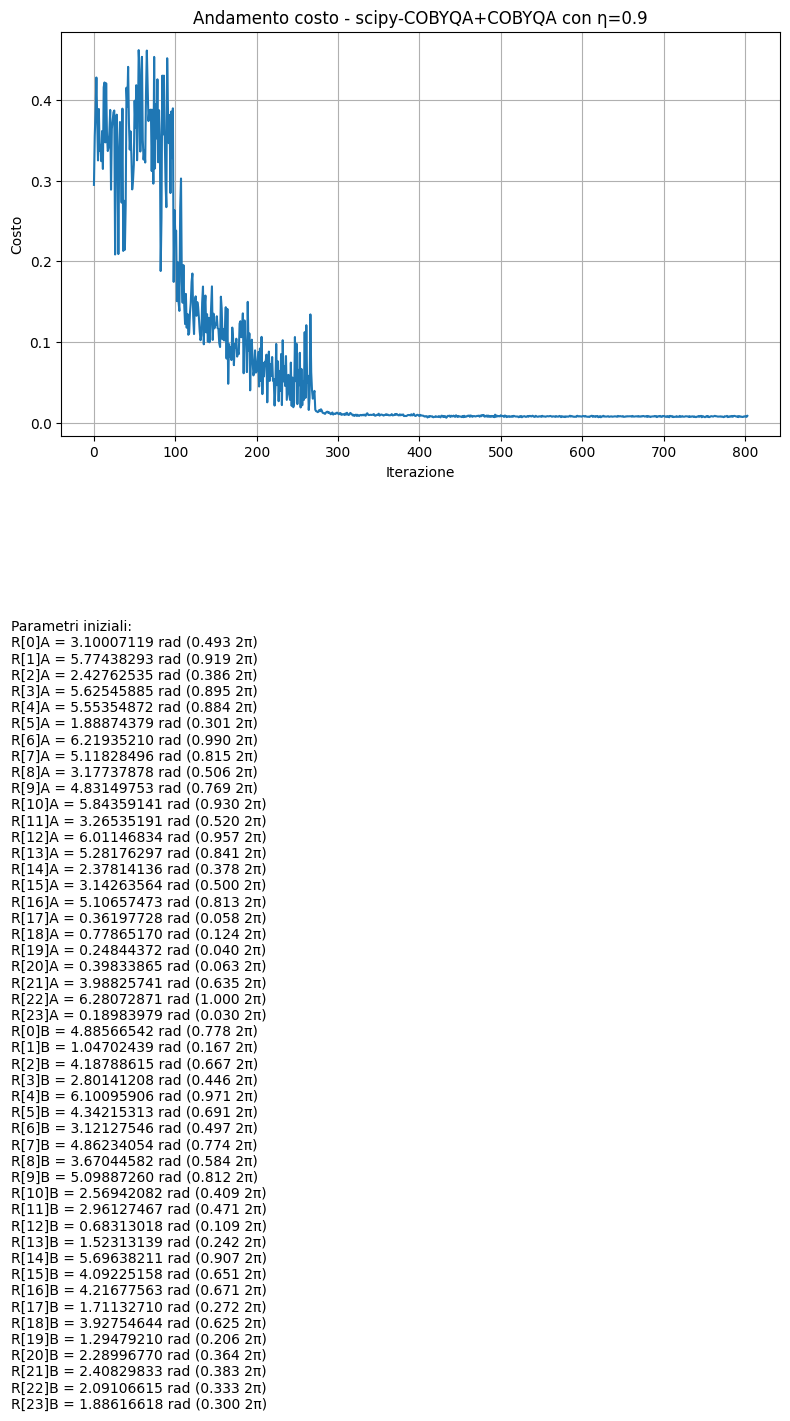

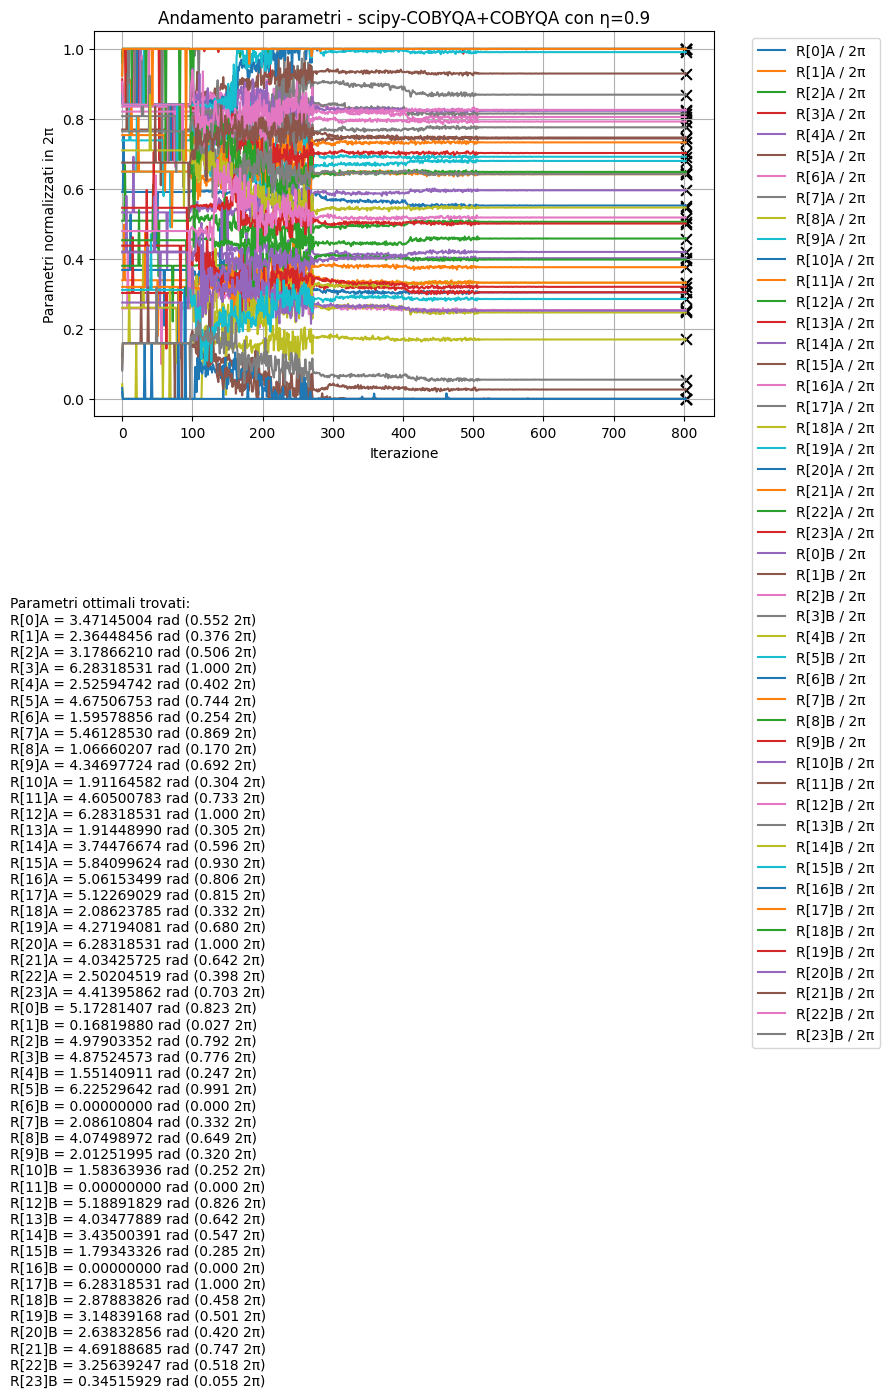

In [71]:
import matplotlib.pyplot as plt
for elem in all_simulation:
    result, cost_history, n = elem
    cost, param = ( lambda arr: (
        arr[:, 0].tolist(),           # lista dei costi
        arr[:, 1:].tolist()           # lista delle liste dei parametri
    ))(np.array(cost_history))
    
    param = np.array(param)

    pr = [p.name + "A" for p in new_param_circuit]
    pr.extend([p.name + "B" for p in new_param_circuit])
    # print(pr)
    fig0, ax = plt.subplots(figsize=(8, 5))
    ax.plot(cost)
    ax.set_xlabel("Iterazione")
    ax.set_ylabel("Costo")
    ax.set_title(f"Andamento costo - scipy-{met0}+{met1} con η={n}")
    ax.grid(True)
    # Aggiunge i valori finali fuori dal grafico, ad esempio in basso
    initial_values_text = "\n".join([
        f"{pr[i]} = {x0[i]:.8f} rad ({x0[i]/(2*np.pi):.3f} 2π)"
        for i in range(len(x0))
    ])

    fig0.text(0.02, -0.25, f"Parametri iniziali:\n{initial_values_text}",
            fontsize=10, va='top', ha='left')

    plt.tight_layout()
    #display(fig)
    

    fig1, ax = plt.subplots(figsize=(8, 5))

    # Traccia l'andamento dei parametri
    for i in range(param.shape[1]):
        ax.plot(param[:, i] / (2*np.pi), label=f"{pr[i]} / 2π")
        ax.scatter(len(param) - 1, result.x[i] / (2*np.pi), color='black', marker='x', s=60)

    ax.set_xlabel("Iterazione")
    ax.set_ylabel("Parametri normalizzati in 2π")
    ax.set_title(f"Andamento parametri - scipy-{met0}+{met1} con η={n}")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # sposta a destra fuori dal grafico
    ax.grid(True)

    # Aggiunge i valori finali fuori dal grafico, ad esempio in basso
    final_values_text = "\n".join([
        f"{pr[i]} = {result.x[i]:.8f} rad ({result.x[i]/(2*np.pi):.3f} 2π)"
        for i in range(len(result.x))
    ])

    fig1.text(0.02, -0.25, f"Parametri ottimali trovati:\n{final_values_text}",
            fontsize=10, va='top', ha='left')

    plt.tight_layout()
    if save : 
        salva_plot_png(fig0, f"costo_damping_{n}", radice, risultati, _create=True, name_create=f"damping_{n}")
        salva_plot_png(fig1,f"parametri_damping_{n}",radice,risultati,_create = True,name_create=f"damping_{n}")

## grafici istogrammi degli stati e matrici densità prima di amplitude damping, il decoding amplitude damping e anche prima della misura del canale

### Preparazione delle singole componenti del canale

Esperimento con rumore 0.0
Istogramma dopo Ansatz d'ingresso, operatore di 'encoding', prima di essere soggetto a rumore


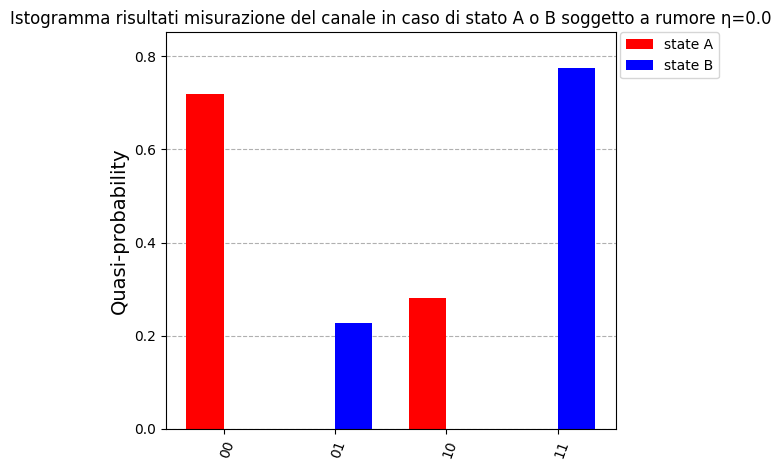

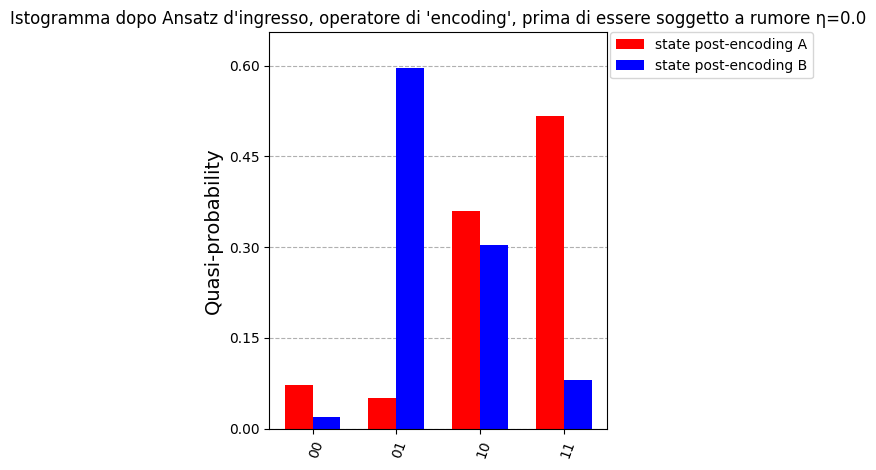

matrice densita stato A dopo Ansatz di ingresso


<IPython.core.display.Latex object>

matrice densita stato A dopo Ansatz di uscita invertito nel tempo


<IPython.core.display.Latex object>

matrice densita stato B dopo Ansatz di ingresso


<IPython.core.display.Latex object>

matrice densita stato B dopo Ansatz di uscita invertito nel tempo


<IPython.core.display.Latex object>

Esperimento con rumore 0.225
Istogramma dopo Ansatz d'ingresso, operatore di 'encoding', prima di essere soggetto a rumore


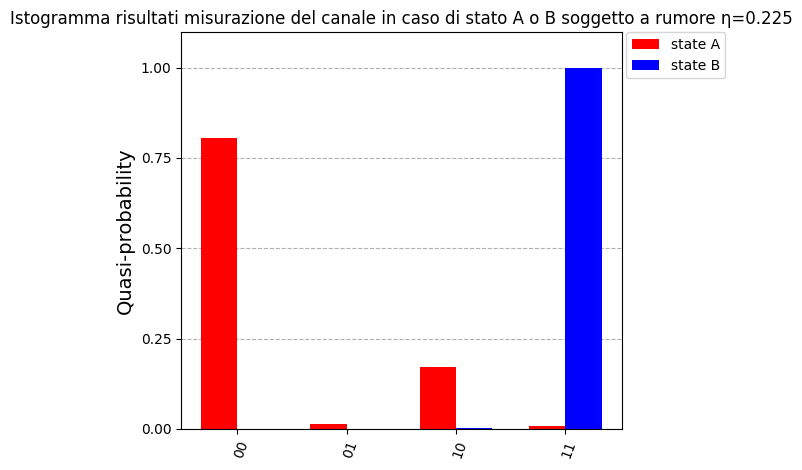

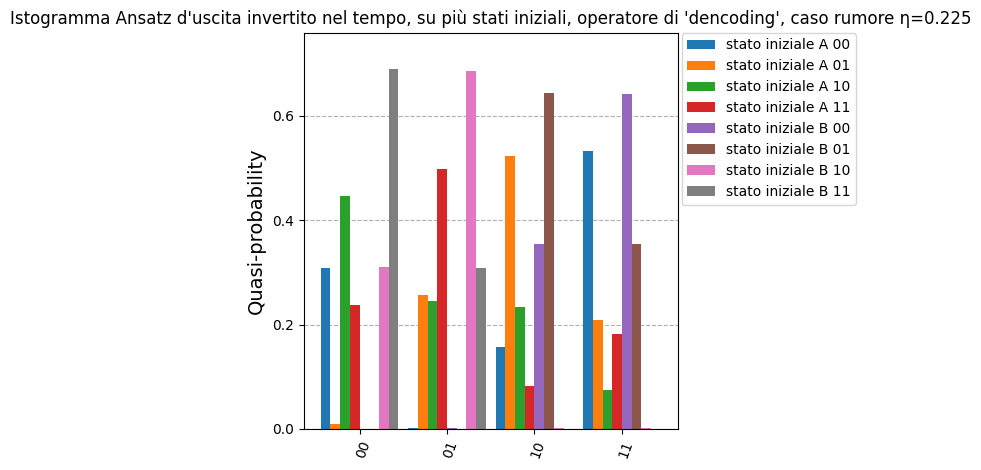

matrice densita stato A dopo Ansatz di ingresso


<IPython.core.display.Latex object>

matrice densita stato A dopo Ansatz di uscita invertito nel tempo


<IPython.core.display.Latex object>

matrice densita stato B dopo Ansatz di ingresso


<IPython.core.display.Latex object>

matrice densita stato B dopo Ansatz di uscita invertito nel tempo


<IPython.core.display.Latex object>

Esperimento con rumore 0.45
Istogramma dopo Ansatz d'ingresso, operatore di 'encoding', prima di essere soggetto a rumore


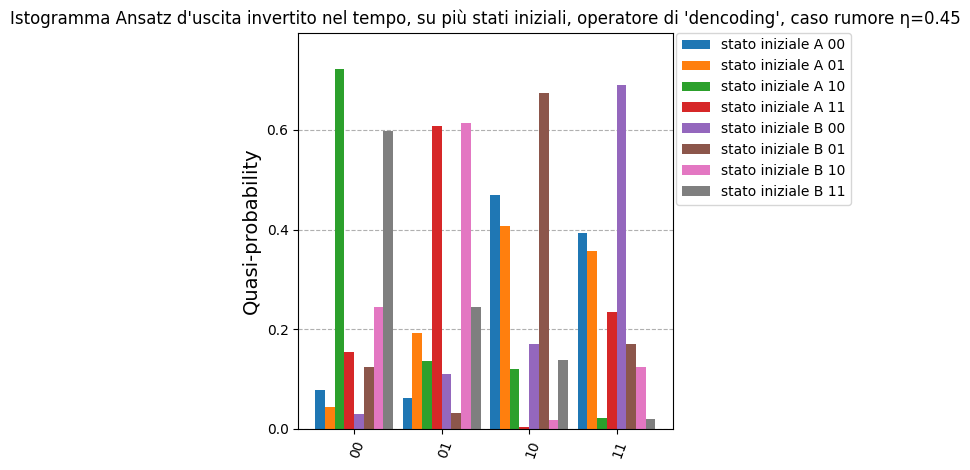

matrice densita stato A dopo Ansatz di ingresso


<IPython.core.display.Latex object>

matrice densita stato A dopo Ansatz di uscita invertito nel tempo


<IPython.core.display.Latex object>

matrice densita stato B dopo Ansatz di ingresso


<IPython.core.display.Latex object>

matrice densita stato B dopo Ansatz di uscita invertito nel tempo


<IPython.core.display.Latex object>

Esperimento con rumore 0.675
Istogramma dopo Ansatz d'ingresso, operatore di 'encoding', prima di essere soggetto a rumore


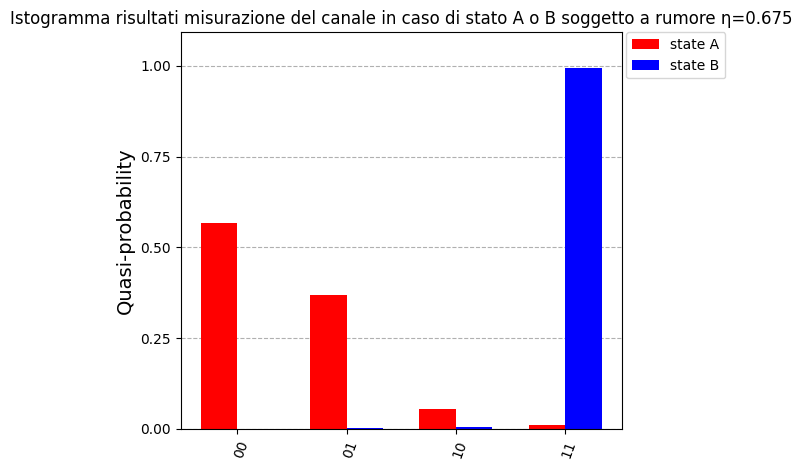

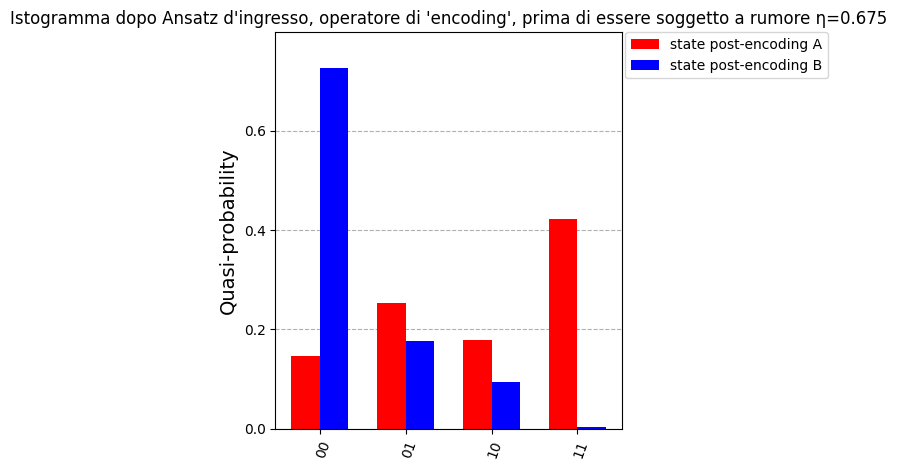

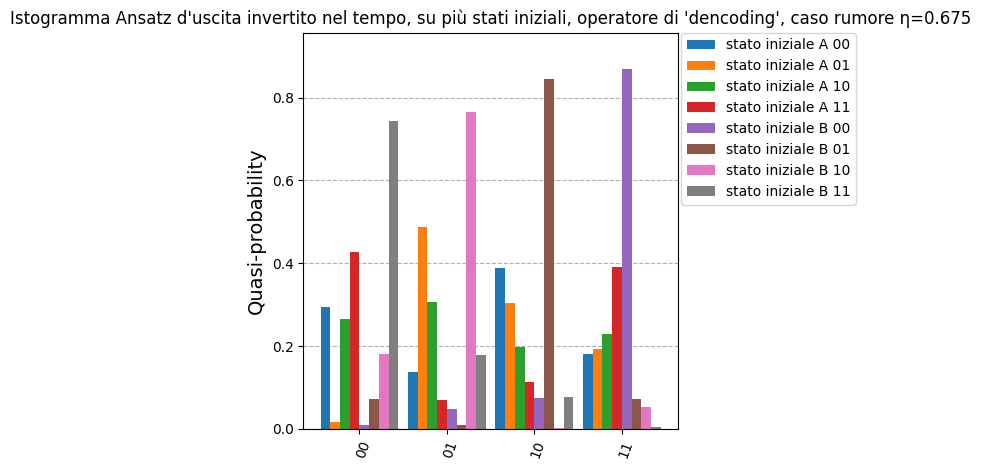

matrice densita stato A dopo Ansatz di ingresso


<IPython.core.display.Latex object>

matrice densita stato A dopo Ansatz di uscita invertito nel tempo


<IPython.core.display.Latex object>

matrice densita stato B dopo Ansatz di ingresso


<IPython.core.display.Latex object>

matrice densita stato B dopo Ansatz di uscita invertito nel tempo


<IPython.core.display.Latex object>

Esperimento con rumore 0.9
Istogramma dopo Ansatz d'ingresso, operatore di 'encoding', prima di essere soggetto a rumore


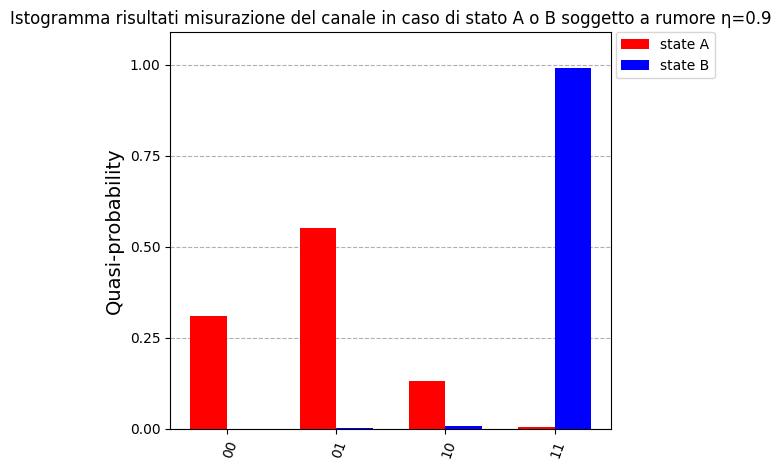

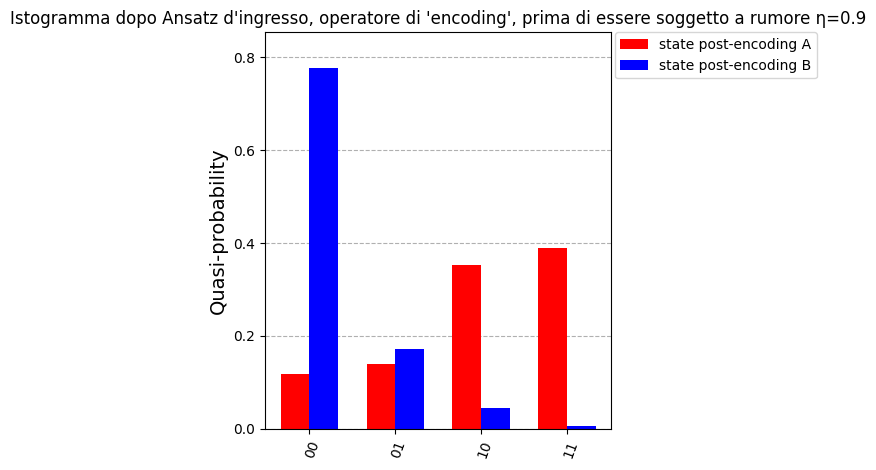

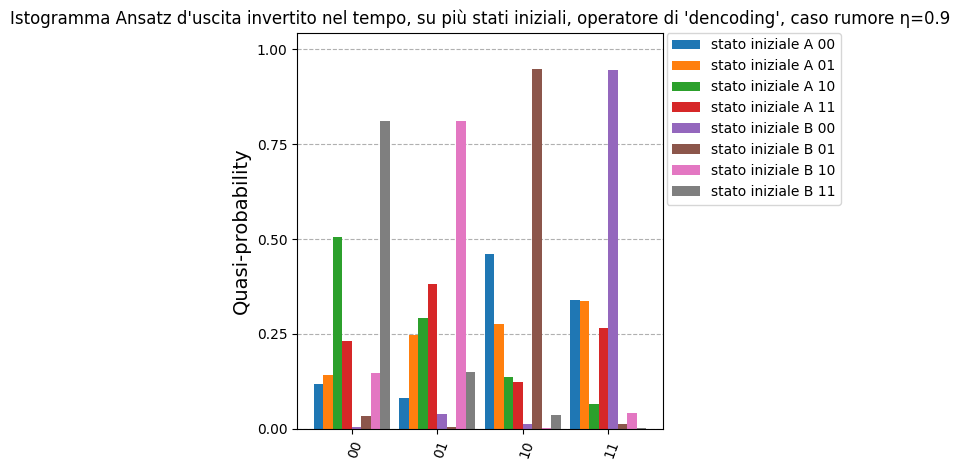

matrice densita stato A dopo Ansatz di ingresso


<IPython.core.display.Latex object>

matrice densita stato A dopo Ansatz di uscita invertito nel tempo


<IPython.core.display.Latex object>

matrice densita stato B dopo Ansatz di ingresso


<IPython.core.display.Latex object>

matrice densita stato B dopo Ansatz di uscita invertito nel tempo


<IPython.core.display.Latex object>

In [77]:
from qiskit.visualization import plot_histogram
En_for_data = En.copy()
De_in_for_data = De.inverse()
qc_for_data = qc_exp.copy()
counts = 100000
final_state_meas = ["00","01","10","11"]
for elem in all_simulation:
    result, cost_history, n = elem
    ex = qc_for_data.assign_parameters({noise:n})
    dA = {param_circuit[i] : result.x[i] for i in range(len(param_circuit))}
    dB = {param_circuit[i] : result.x[i+len(param_circuit)] for i in range(len(param_circuit))}

    print(f"Esperimento con rumore {n}")
    print("Istogramma dopo Ansatz d'ingresso, operatore di 'encoding', prima di essere soggetto a rumore")
    results = IdealSimulator().run([(ex,dA,counts),(ex,dB,counts)])
    normalize_data =[{k: v/counts for k, v in results[i].data.c.get_counts().items()} for i in range(2)]
    image0 = plot_histogram(data=normalize_data,
                           legend=["state A", "state B"],
                           color=["red","blue"]
                           ,title=f"Istogramma risultati misurazione del canale in caso di stato A o B soggetto a rumore η={n}",
                           bar_labels=False)
    display(image0)
    En_meas = QuantumCircuit(2,2).compose(En_for_data.copy(), [0,1])
    En_meas.measure(0,0)
    En_meas.measure(1,1)
    results = IdealSimulator().run([(En_meas.assign_parameters(dA,strict=False),[],counts),(En_meas.assign_parameters(dB,strict=False),[],counts)])
    normalize_data =[{k: v/counts for k, v in results[i].data.c.get_counts().items()} for i in range(2)]
    image1 = plot_histogram(data=normalize_data,
                           legend=["state post-encoding A", "state post-encoding B"],
                           color=["red","blue"]
                           ,title=f"Istogramma dopo Ansatz d'ingresso, operatore di 'encoding', prima di essere soggetto a rumore η={n}",
                           bar_labels=False)
    display(image1)
    De_meas = QuantumCircuit(2,2)
    De_meas.compose(De_in_for_data.copy(), [0,1],inplace=True)
    De_meas.measure(0,0)
    De_meas.measure(1,1)
    De_meases = []
    for i in range(len(final_state_meas)):
        t = De_meas.copy()
        t.initialize(Statevector.from_label(final_state_meas[i]),[0,1])
        t.compose(De_meas,[0,1],inplace=True)
        De_meases.append(t)
    pubs = [(De_meases[i].assign_parameters(d,strict=False),[],counts) for d in [dA,dB] for i in range(len(final_state_meas))]
    results = IdealSimulator().run(pubs)
    normalize_data =[{k: v/counts for k, v in r.data.c.get_counts().items()} for r in results]
    image2 = plot_histogram(data=normalize_data,
                           legend=[f"stato iniziale {l} {i}" for l in ["A","B"]for i in final_state_meas],
                        #    color=["red","blue"],
                           title=f"Istogramma Ansatz d'uscita invertito nel tempo, su più stati iniziali, operatore di 'dencoding', caso rumore η={n}",
                           bar_labels=False)
    display(image2)

    print("matrice densita stato A dopo Ansatz di ingresso")
    display(DensityMatrix.from_label("00").evolve(En_for_data.assign_parameters(dA,strict=False)).draw("latex"))
    print("matrice densita stato A dopo Ansatz di uscita invertito nel tempo")
    display(DensityMatrix.from_label("00").evolve(De_in_for_data.assign_parameters(dA,strict=False)).draw("latex"))
    print("matrice densita stato B dopo Ansatz di ingresso")
    display(DensityMatrix.from_label("00").evolve(En_for_data.assign_parameters(dB,strict=False)).draw("latex"))
    print("matrice densita stato B dopo Ansatz di uscita invertito nel tempo")
    display(DensityMatrix.from_label("00").evolve(De_in_for_data.assign_parameters(dB,strict=False)).draw("latex"))
    if save : 
        salva_plot_png(image1, f"Isto_distribuzione_encoder_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
        salva_plot_png(image0, f"Isto_distribuzione_finale_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
        salva_plot_png(En_for_data.draw("mpl"),"circuito_visualizzazione_encoding",radice,visualizzazione)
        salva_plot_png(De_in_for_data.draw("mpl"),"circuito_visualizzazione_decoding",radice,visualizzazione)
        salva_plot_png(qc_for_data.draw("mpl"),"circuito_completo",radice,visualizzazione)
        salva_plot_png(image2, f"Isto_distribuzione_decoder_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
        salva_plot_png(DensityMatrix.from_label("00").evolve(En_for_data.assign_parameters(dA,strict=False)).draw("city")
                    , f"matrice_encode_A_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
        salva_plot_png(DensityMatrix.from_label("00").evolve(De_in_for_data.assign_parameters(dA,strict=False)).draw("city")
                    , f"matrice_decode_A_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
        salva_plot_png(DensityMatrix.from_label("00").evolve(En_for_data.assign_parameters(dB,strict=False)).draw("city")
                    , f"matrice_encode_B_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
        salva_plot_png(DensityMatrix.from_label("00").evolve(De_in_for_data.assign_parameters(dB,strict=False)).draw("city")
                    , f"matrice_decode_B_{n}",radice,visualizzazione,_create = True, name_create = f"damping_{n}")
